# Задание

Модель **RUDOLPH** реализует архитектуру Трансформер для решения ряда задач в двух модальностях (текст и изображение). 
 
В процессе предобучения на входи модели подавались следующие пары входных данных (3 типа решаемых задач):

1.	**text-to-image** (image generation task)
2.	**image-to-text** (image captioning task)
3.	**text-to-text** (language modeling task)

Для того, чтобы модель имела представление о том, какую задачу ей предстоит решить для конкретного входного примера (а также для способности модели адаптироваться под решение новых задач), в токенизированную входную последовательность добавляются спец. символы, определяющие решаемую задачу.

На стадии предобучения, модель видела ограниченный набор спец. символов:
 
*  \<LT_T2I> - text-to-image
*  \<LT_I2T> - image-to-text
*  \<LT_T2T> - text-to-text
*  \<RT_I2T> - image-to-text
*  \<LT_UNK>
*  \<RT_UNK>

При дообучении модели под дополнительную задачу, например, Text QA, мы можем добавить определенные спец. символы для этой задачи (например, \<LT_TQA> и \<RT_TQA>).

Рассмотрим пример для задачи image captioning. Входная последовательность токенов выглядит следующим образом:
```
<BOS> <LT_ T2I> left_text_tokens <EOS> | image_tokens | <RT_I2T> …
```
**\<LT_T2I>** - спец. символ для левых текстовых токенов, определяющий перевод текста в изображение. <br>
**\<RT_I2T>** - спец. символ для правых текстовых токенов, определяющий генерацию текста по изображению.

В 25% обучающих примеров, определенные токены для задачи заменяются на соответствующие им неизвестные токены (\<LT_UNK> и \<RT_UNK>) для того чтобы модель могла адаптироваться под решение новых и неизвестных задач.

Помимо того, что модель учится генерировать контексто-зависимые векторные представления спец-символом, их также можно использовать в качестве дополнительного источника информации о задаче. Например, можно обучить классификатор, который по векторному представлению спец-токена будет определять, какой тип задачи решает модель. 

В качестве задания предлагается провести дообучение модели, например, для задач visual qa и image captioning. При дообучении нужно рассчитать не только loss по сгенерированному моделью тексту, но и дополнительный loss для многоклассовой классификации по усредненному векторному представлению спец. символа для правого и левого текстов, который будет определять, к какому типу задачи относится входной пример.

# Setting up environment

In [1]:
%load_ext autoreload
%autoreload 2

## Installations

In [2]:
# ! pip install --quiet wget
! pip install --quiet omegaconf youtokentome catalyst bitsandbytes wandb rudalle umap-learn

     |████████████████████████████████| 79 kB 943 kB/s 
     |████████████████████████████████| 1.7 MB 34.9 MB/s 
     |████████████████████████████████| 446 kB 36.8 MB/s 
     |████████████████████████████████| 62.5 MB 18 kB/s 
     |████████████████████████████████| 1.9 MB 41.4 MB/s 
     |████████████████████████████████| 40 kB 3.9 MB/s 
     |████████████████████████████████| 117 kB 40.6 MB/s 
     |████████████████████████████████| 148 kB 44.6 MB/s 
     |████████████████████████████████| 125 kB 42.9 MB/s 
     |████████████████████████████████| 166 kB 43.7 MB/s 
     |████████████████████████████████| 182 kB 46.6 MB/s 
     |████████████████████████████████| 63 kB 1.4 MB/s 
     |████████████████████████████████| 166 kB 42.1 MB/s 
     |████████████████████████████████| 162 kB 9.9 MB/s 
     |████████████████████████████████| 162 kB 41.0 MB/s 
     |████████████████████████████████| 158 kB 41.1 MB/s 
     |████████████████████████████████| 157 kB 47.3 MB/s 
     |████████████████

## Imports

In [3]:
# Visualizations
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="white", context="talk")
plt.style.use('default')
%matplotlib inline

In [4]:
import os
import gc
import sys
import json
import shutil
import random
import string
from pathlib import Path


import itertools
import collections
import numpy as np
import pandas as pd
from pprint import pprint
from tqdm import tqdm, tqdm_notebook

from omegaconf import OmegaConf
from typing import (List, Dict, Any, Tuple, Optional, 
                    Union, Callable)
# Image utils
import cv2
from PIL import Image
import torchvision.transforms as T

# Modelling
import torch
from sklearn.model_selection import train_test_split
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, DataLoader
import youtokentome as yttm
import bitsandbytes as bnb

import warnings
warnings.filterwarnings("ignore")

import logging
logging.basicConfig(format='%(levelname)s: %(message)s', level=logging.INFO)

CUDA SETUP: Required library version not found: libsbitsandbytes_cpu.so. Maybe you need to compile it from source?
CUDA SETUP: Defaulting to libbitsandbytes.so...

================================================ERROR=====================================
CUDA SETUP: CUDA detection failed! Possible reasons:
1. CUDA driver not installed
2. CUDA not installed
3. You have multiple conflicting CUDA libraries
4. Required library not pre-compiled for this bitsandbytes release!
CUDA SETUP: If you compiled from source, try again with `make CUDA_VERSION=DETECTED_CUDA_VERSION` for example, `make CUDA_VERSION=113`.

CUDA SETUP: Problem: The main issue seems to be that the main CUDA library was not detected.
CUDA SETUP: Solution 1): Your paths are probably not up-to-date. You can update them via: sudo ldconfig.
CUDA SETUP: Solution 2): If you do not have sudo rights, you can do the following:
CUDA SETUP: Solution 2a): Find the cuda library via: find / -name libcuda.so 2>/dev/null
CUDA SETUP: Soluti

/usr/local/lib/python3.7/dist-packages/bitsandbytes/cextension.py:127: UserWarning: The installed version of bitsandbytes was compiled without GPU support. 8-bit optimizers and GPU quantization are unavailable.
  warn("The installed version of bitsandbytes was compiled without GPU support. "


## Mount drive & paths

In [5]:
REPO_LINK ="https://github.com/IrinaArmstrong/ru-dolph.git"
BRANCH= "clf_sp_tokens_loss"
clone_repo_prompt = f"git clone -b {BRANCH} {REPO_LINK}"

REPO_NAME = "ru-dolph"

try:
    import google.colab
    IN_COLAB = True
    print(f"Running notebook in Google Colab...")
except:
    print(f"Running notebook locally...")
    IN_COLAB = False

if IN_COLAB:
    
    from google.colab import drive
    ROOT_PATH = Path('/content/drive')
    drive.mount(str(ROOT_PATH),  force_remount=True)
    print(f"Root path: {ROOT_PATH}")
    BASE_DIR = Path("/content/drive/MyDrive/DS Data&Notebooks/Ru-DOLPH")
    DATA_DIR = BASE_DIR.parent / "Data"
    OUTPUT_DIR = BASE_DIR / "outputs"
    MODEL_PRETRAINED_DIR = BASE_DIR / "weights"
    MODEL_CHKP_DIR = BASE_DIR / "outputs" / "checkpoints"
else:
    ROOT_PATH = Path().parent.resolve()
    print(f"Root path: {ROOT_PATH}")

REPO_PATH = ROOT_PATH.parent / REPO_NAME

if REPO_PATH.exists():
    print(f"Repository already exists by path: {REPO_PATH}")
    reclone = input("Want to clone once again? (y/n)")
    if reclone== "y":
        # Clear place
        shutil.rmtree(REPO_PATH.resolve())
        # Cloning
        print("Cloning...")
        os.system(clone_repo_prompt) 
        sys.path.insert(1, REPO_NAME)
        print(f"Repository cloned to path: {REPO_PATH}")
    else:
        print("Ok")
        sys.path.insert(1, REPO_NAME)
else:
    # Cloning
    print("Cloning...")
    os.system(clone_repo_prompt)
    sys.path.insert(1, REPO_NAME)

Running notebook in Google Colab...
Mounted at /content/drive
Root path: /content/drive
Cloning...


In [6]:
# Check repository
if not REPO_PATH.exists():
    print(f"Repository do not exists by path: {REPO_PATH} !", file=sys.stderr)

In [7]:
# !cd ru-dolph && git checkout task_tokens_loss > /dev/null
# !pip install -r 'ru-dolph/requirements.txt' > /dev/null

## Device & Reproducibility

In [7]:
def acquire_device(device_type: str='cpu'):
    """ Init training device. """
    print(f"Training device provided: {device_type}")

    if device_type == 'cuda':
        if not torch.cuda.is_available():
            print(f"Device provided is CUDA, but it is unavailable. Changing to CPU.")
            device = torch.device('cpu')
        else:
            device = torch.device(device_type)
            print(torch.cuda.get_device_name(0))
            print('Memory Usage, Allocated:', round(torch.cuda.memory_allocated(0) / 1024 ** 3, 1), 'GB')
            print('Memory Usage, Cached:', round(torch.cuda.memory_reserved(0) / 1024 ** 3, 1), 'GB')
    else:
        device = torch.device(device_type)
    print(f"Training device mounted: {device.type}")
    return device

def seed_everything(seed_value: int):
    random.seed(seed_value)  # Python
    np.random.seed(seed_value)  # cpu vars
    torch.manual_seed(seed_value)  # cpu  vars
    os.environ['PYTHONHASHSEED'] = str(seed_value)

    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed_value)  # for using CUDA backend
        torch.cuda.manual_seed_all(seed_value)  # gpu vars
        torch.backends.cudnn.deterministic = True  # get rid of nondeterminism
        torch.backends.cudnn.benchmark = True

# Set device
device = acquire_device("cuda")
print(f"Selected device: {device}")
seed_everything(11)

Training device provided: cuda
Device provided is CUDA, but it is unavailable. Changing to CPU.
Training device mounted: cpu
Selected device: cpu


In [8]:
%%writefile gpu_usage.sh
#! /bin/bash
#comment: run for 10 seconds, change it as per your use
end=$((SECONDS+10))

while [ $SECONDS -lt $end ]; do
    nvidia-smi --format=csv --query-gpu=power.draw,utilization.gpu,memory.used,memory.free,fan.speed,temperature.gpu >> gpu.log
    #comment: or use below command and comment above using #
    #nvidia-smi dmon -i 0 -s mu -d 1 -o TD >> gpu.log
done

Writing gpu_usage.sh


In [9]:
%%bash --bg

bash gpu_usage.sh

## Configuration

In [11]:
config_path = REPO_PATH / "configuration" / "multi_task_ft.yaml"
if config_path.exists():
    config = OmegaConf.load(str(config_path))
    print(OmegaConf.to_yaml(config))
else:
    print(f"No configuration file found by path:\n{config_path}")
    print(f"Check provided locations and try again.")

tasks:
  vqa: true
  captioning: true
data:
  captioning:
    dataset_path: /content/drive/MyDrive/DS Data&Notebooks/Data/Image_Captioning_COCO-2014/
    train_input: /content/drive/MyDrive/DS Data&Notebooks/Data/Image_Captioning_COCO-2014/captioning.json
    train_output: /content/drive/MyDrive/DS Data&Notebooks/Data/Image_Captioning_COCO-2014/captioning_answers.json
    val_input: /content/drive/MyDrive/DS Data&Notebooks/Data/Image_Captioning_COCO-2014/captioning_val.json
    val_output: /content/drive/MyDrive/DS Data&Notebooks/Data/Image_Captioning_COCO-2014/captioning_val_answer.json
  vqa:
    dataset_path: /content/drive/MyDrive/DS Data&Notebooks/Data/VQA_VisualGenome/
    train_input: /content/drive/MyDrive/DS Data&Notebooks/Data/VQA_VisualGenome/vqa_train.json
    train_output: /content/drive/MyDrive/DS Data&Notebooks/Data/VQA_VisualGenome/vqa_train_answer.json
    val_input: /content/drive/MyDrive/DS Data&Notebooks/Data/VQA_VisualGenome/vqa_val.json
    val_output: /content/dr

In [12]:
# Set device
config['trainer'].bs = 2
config['model'].rudolph.device = "cuda"
config['trainer'].pl_trainer.gpus = 1
config['trainer'].pl_trainer.max_epochs = 1

# Datasets

In [ ]:
from rudolph.train.utils import create_dataset

In [13]:
TASKS = ["vqa",
         "captioning"]

VQA_PATH = config['data']['vqa']['dataset_path']  # or DATA_DIR / "VQA_VisualGenome"
IMCAP_PATH = config['data']['captioning']['dataset_path']  # or DATA_DIR / "Image_Captioning_COCO-2014"

dataset_paths = {}
for task_name, path in zip(TASKS, [VQA_PATH, IMCAP_PATH]):
    dataset_paths[task_name] = str(path)

## Load data (if not loaded)

In [ ]:
import io
import wget
import requests
import tarfile
import zipfile

In [ ]:
# Load dataset
def download_data(url: str, extract_folder: Union[str, Path]) -> Union[str, List[str]]:
    """ Load file by url to selected folder. """
    extract_folder= Path(extract_folder).resolve()
    if not extract_folder.exists():
        logging.warning(f"Creating extraction folder: {extract_folder}...")
        extract_folder.mkdir()
    try:
        filename = wget.download(url, str(extract_folder / os.path.split(url)[-1]))
    except Exception as e:
        logging.error(f"Something went wrong during data loading. Error code: {e}")
        return None
    logging.info(f"Data successfully loaded to: {extract_folder}")
    return filename

In [ ]:
def extract_zip_data(filename: str, extract_folder: Union[str, Path]) -> List[str]:
    extract_folder = Path(extract_folder)
    if filename.endswith("zip"):
        logging.info(f"Loaded file is archived, extracting...")
        try:
            with zipfile.ZipFile(str(filename), 'r') as zip_ref:
                zip_ref.extractall(str(extract_folder))
            return list(extract_folder.glob("*"))
        except Exception as e:
            logging.error(f"Something went wrong during data archive extraction. Error code: {e}")
            return [filename]
    return [filename]

def extract_targz_data(filename: str, extract_folder: Union[str, Path]) -> List[str]:
    extract_folder = Path(extract_folder)
    if filename.endswith("tar.gz"):
        logging.info(f"Loaded file is archived, extracting...")
        try:
            with tarfile.TarFile(str(filename), 'r') as tar_ref:
                tar_ref.extractall(str(extract_folder))
            return list(extract_folder.glob("*"))
        except Exception as e:
            logging.error(f"Something went wrong during data archive extraction. Error code: {e}")
            return [filename]
    return [filename]

In [ ]:
VQA_LINK = "https://n-ws-f21jf.s3pd02.sbercloud.ru/b-ws-f21jf-ny6/FBC2/captioning_vqa/vqa.tar.gz"
IMCAP_LINK = "https://n-ws-f21jf.s3pd02.sbercloud.ru/b-ws-f21jf-ny6/FBC2/captioning_vqa/captioning.tar.gz"

dataset_links = {}
for task_name, link in zip(TASKS, [VQA_LINK, IMCAP_LINK]):
    dataset_links[task_name] = link

print(TASKS)

['vqa', 'captioning']


In [ ]:
task_name = 'captioning'
link = dataset_links[task_name]
extract_folder = dataset_paths[task_name]

loaded_filename = download_data(link, extract_folder)
print(f"Loaded to file: {loaded_filename}")

Loaded to file: /content/drive/MyDrive/DS Data&Notebooks/Data/Image_Captioning_COCO-2014/captioning.tar.gz


In [ ]:
files = extract_targz_data(loaded_filename, extract_folder)

# Image Captioning (ImageCaptioning)

## Description 

This sub-task assesses the model's ability to generate textual descriptions of images in Russian. An answer to the sub-task shall be a text string containing a description of the input image contents.

## Data

**Train** 

It is proposed to use the [COCO data set](https://cocodataset.org) for training, which contains "text-picture" pairs; all textual descriptions can be translated into Russian by a translator.

For the convenience, we prepared training dataset for TextQA sub-task (the data can be found in the corresponding folder of the [archive](https://n-ws-f21jf.s3pd02.sbercloud.ru/b-ws-f21jf-ny6/FBC2/fb_train_2022.tar.gz)) in the same format as Test public and Test private sets.

### ImageCaptioning test data format

**Test public** 

The testing data set contains the textual statement of sub-task to be solved, and a request, for which it is necessary to generate an image. The format of testing examples is similar to the _input.json_ format of the training data set.

ImageCaptioning sample from _input.json_ has the following format:

```
{
"0": [{"type": "text", "content": "Что представлено на картинке?"}, {"type": "image", "content": "images/00000.jpg"}],
...
}
```

Image Example:

`images/00000.jpg`: 

<img src="https://n-ws-f21jf.s3pd02.sbercloud.ru/b-ws-f21jf-ny6/FBC2/images_web/image-caption.png" width=250>

ImageCaptioning ground truth from _ground\ truth.json_ has the following format:

```
{
"0": [{"type": "text", "content": ["Торт со светло-бежевой глазурью, украшенный фигуркой медведя, держащий связку воздушных шариков.", "Детский торт, покрытый светлой глазурью с украшением в виде медвежонка."]}],
...
}
```


In [15]:
task_config = config['data']['captioning']
captioning_ds = create_dataset('captioning',
                               dataset_path=task_config['dataset_path'],
                               train_input=task_config['train_input'], 
                               train_output=task_config['train_output'], 
                               val_input=task_config['val_input'], 
                               val_output=task_config['val_output'])

captioning_df = pd.DataFrame(captioning_ds)
print(f"Image captioning data: {captioning_df.shape}\n")
print(f"\n{captioning_df.info()}\n")
captioning_df.head()

Image captioning data: (23000, 5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23000 entries, 0 to 22999
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   task_id     23000 non-null  object
 1   left_text   23000 non-null  object
 2   image_path  23000 non-null  object
 3   right_text  23000 non-null  object
 4   stage       23000 non-null  object
dtypes: object(5)
memory usage: 898.6+ KB

None



,task_id,left_text,image_path,right_text,stage
0,captioning,Что происходит на картинке?,/content/drive/MyDrive/DS Data&Notebooks/Data/...,"Часы, которые смешиваются со стеной, висят в в...",train
1,captioning,Опиши изображение.,/content/drive/MyDrive/DS Data&Notebooks/Data/...,Кухня с обшарпанным полом и белыми шкафами.,train
2,captioning,Опиши изображение.,/content/drive/MyDrive/DS Data&Notebooks/Data/...,"Уличный знак с надписью ""Стоп-хаус"".",train
3,captioning,Опиши изображение.,/content/drive/MyDrive/DS Data&Notebooks/Data/...,Парень и девушка идут по пляжу с досками для с...,train
4,captioning,Опиши сцену на изображении.,/content/drive/MyDrive/DS Data&Notebooks/Data/...,голубая ванная комната с раковиной и туалетом,train


In [16]:
# Train vs. validation splits
print("As-is:")
print(captioning_df['stage'].value_counts())
print("\nPercentage:")
print(captioning_df['stage'].value_counts(normalize=True))

As-is:
train    20000
val       3000
Name: stage, dtype: int64

Percentage:
train    0.869565
val      0.130435
Name: stage, dtype: float64


In [17]:
print(f"There are {captioning_df['image_path'].nunique()} unique "
      f"images from {captioning_df.shape[0]} samples in dataset")

print(f"In train subset:\n\t{captioning_df.loc[captioning_df['stage'] == 'train']['image_path'].nunique()}"
      f" from {captioning_df.loc[captioning_df['stage'] == 'train'].shape[0]} total")

print(f"In validation subset:\n\t{captioning_df.loc[captioning_df['stage'] == 'val']['image_path'].nunique()}"
      f" from {captioning_df.loc[captioning_df['stage'] == 'val'].shape[0]} total")

There are 23000 unique images from 23000 samples in dataset
In train subset:
	20000 from 20000 total
In validation subset:
	3000 from 3000 total


In [18]:
# Check images paths
# captioning_df['image_path'].apply(lambda x: Path(x).exists()).value_counts()

In [19]:
captioning_train_df = captioning_df.loc[captioning_df['stage'] == 'train']
captioning_val_df = captioning_df.loc[captioning_df['stage'] == 'val']

print(f"Train: {captioning_train_df.shape} samples")
print(f"Val: {captioning_val_df.shape} samples")

Train: (20000, 5) samples
Val: (3000, 5) samples


## Separate test subset

In [20]:
captioning_train_df_, captioning_test_df = train_test_split(captioning_train_df, 
                                                            test_size=0.2,
                                                            random_state=42)

print(f"Train: {captioning_train_df_.shape} samples")
print(f"Test: {captioning_test_df.shape} samples")

Train: (16000, 5) samples
Test: (4000, 5) samples


# Visual QA (VisualQA)

## Description 

The sub-task provides that a trained model is able to generate an answer to the question based on an image. In this sub-task, the model receives a "textual question - picture" pair at the input, and it should return the corresponding textual answer at the output. If only a question is given to the input image, the model should generate an appropriate answer; if there are also some answer options to the input text, the model should choose the correct one (there may be 4 answer options and only one of them is correct).

## Data

**Train** 

It is proposed to use the [Visual Genome data set](https://visualgenome.org/api/v0/api_home.html) for training, which contains "question-answer" pairs with pictures. All questions and answers can be translated by a translator. 

For the convenience, we prepared training dataset for TextQA sub-task (the data can be found in the corresponding folder of the [archive](https://n-ws-f21jf.s3pd02.sbercloud.ru/b-ws-f21jf-ny6/FBC2/fb_train_2022.tar.gz)) in the same format as Test public and Test private sets.

### VisualQA test data format

**Test public** 

The testing data set contains the textual statement of sub-task to be solved (optionally), a question, and an image, for which the question is asked. The format of testing examples is similar to the _input.json_ format of the training data set.

VisualQA sample from _input.json_ has the following format:

```
{
"0": [{"type": "text", "content": "Ответь на вопрос по картинке."}, {"type": "text", "content": "Какого цвета плакат на ограждении?"}, {"type": "image", "content": "images/00000.jpg"}], 
...
}
```

Image example:

`images/00000.jpg`: 

<img src="https://n-ws-f21jf.s3pd02.sbercloud.ru/b-ws-f21jf-ny6/FBC2/images_web/image-2.png" width="250">


VisualQA ground truth from _ground\ truth.json_ has the following format:

```
{
"0": [{"type": "text", "content": ["желтого", "ярко-желтого"]}], 
...
}
```




In [21]:
task_config = config['data']['vqa']
vqa_ds = create_dataset('vqa',
                               dataset_path=task_config['dataset_path'],
                               train_input=task_config['train_input'], 
                               train_output=task_config['train_output'], 
                               val_input=task_config['val_input'], 
                               val_output=task_config['val_output'])

vqa_df = pd.DataFrame(vqa_ds)
print(f"Visual QA data: {vqa_df.shape}\n")
print(f"\n{vqa_df.info()}\n")
vqa_df.head()

Visual QA data: (88761, 5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88761 entries, 0 to 88760
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   task_id     88761 non-null  object
 1   left_text   88761 non-null  object
 2   image_path  88761 non-null  object
 3   right_text  88761 non-null  object
 4   stage       88761 non-null  object
dtypes: object(5)
memory usage: 3.4+ MB

None



,task_id,left_text,image_path,right_text,stage
0,vqa,К чему прикасается этот человек?,/content/drive/MyDrive/DS Data&Notebooks/Data/...,ноутбук,train
1,vqa,Дай ответ на вопрос по картинке. Компьютер вкл...,/content/drive/MyDrive/DS Data&Notebooks/Data/...,нет,train
2,vqa,Что находится по обе стороны от компьютера?,/content/drive/MyDrive/DS Data&Notebooks/Data/...,шкафы,train
3,vqa,Посмотри на картинку и дай ответ на вопрос. Но...,/content/drive/MyDrive/DS Data&Notebooks/Data/...,нет,train
4,vqa,Где это снято?,/content/drive/MyDrive/DS Data&Notebooks/Data/...,рынок,train


In [22]:
# Train vs. validation splits
print("As-is:")
print(vqa_df['stage'].value_counts())
print("\nPercentage:")
print(vqa_df['stage'].value_counts(normalize=True))

As-is:
train    85760
val       3001
Name: stage, dtype: int64

Percentage:
train    0.96619
val      0.03381
Name: stage, dtype: float64


In [23]:
print(f"There are {vqa_df['image_path'].nunique()} unique "
      f"images from {vqa_df.shape[0]} samples in dataset")

print(f"In train subset:\n\t{vqa_df.loc[vqa_df['stage'] == 'train']['image_path'].nunique()}"
      f" from {vqa_df.loc[vqa_df['stage'] == 'train'].shape[0]} total")

print(f"In validation subset:\n\t{vqa_df.loc[vqa_df['stage'] == 'val']['image_path'].nunique()}"
      f" from {vqa_df.loc[vqa_df['stage'] == 'val'].shape[0]} total")

There are 16910 unique images from 88761 samples in dataset
In train subset:
	16332 from 85760 total
In validation subset:
	578 from 3001 total


In [24]:
# Check images paths
# vqa_df['image_path'].apply(lambda x: Path(x).exists()).value_counts()

In [25]:
vqa_train_df = vqa_df.loc[vqa_df['stage'] == 'train']
vqa_val_df = vqa_df.loc[vqa_df['stage'] == 'val']

print(f"Train: {vqa_train_df.shape} samples")
print(f"Val: {vqa_val_df.shape} samples")

Train: (85760, 5) samples
Val: (3001, 5) samples


In [26]:
# Check data leaks
vqa_val_images = vqa_val_df['image_path'].unique()
vqa_train_df['image_path'].apply(lambda x: x in vqa_val_images).value_counts()
# all ok

False    85760
Name: image_path, dtype: int64

## Separate test subset

In [27]:
vqa_train_unique_images = vqa_train_df['image_path'].unique()
print(f"Unique images: {len(vqa_train_unique_images)}")

Unique images: 16332


In [28]:
vqa_train_images_, vqa_test_images = train_test_split(vqa_train_unique_images, 
                                              test_size=0.2,
                                              random_state=42)
vqa_train_df_ = vqa_train_df.loc[vqa_train_df['image_path'].isin(vqa_train_images_)]
vqa_test_df = vqa_train_df.loc[vqa_train_df['image_path'].isin(vqa_test_images)]

print(f"Train: {vqa_train_df_.shape} samples ({vqa_train_df_['image_path'].nunique()} unique)")
print(f"Test: {vqa_test_df.shape} samples ({vqa_test_df['image_path'].nunique()} unique)")

Train: (68593, 5) samples (13065 unique)
Test: (17167, 5) samples (3267 unique)


In [29]:
# Check data leaks
vqa_train_images = vqa_train_df_['image_path'].unique()
vqa_test_df['image_path'].apply(lambda x: x in vqa_train_images).value_counts()
# all ok

False    17167
Name: image_path, dtype: int64

# Multi-task dataset

In [30]:
train_df = pd.concat([captioning_train_df_, vqa_train_df_]) \
                                            .sample(frac=1) \
                                            .reset_index(drop=True)
print(f"Train: {train_df.shape} samples")
print(f"with:")
print(train_df['task_id'].value_counts())

val_df = pd.concat([captioning_val_df, vqa_val_df]) \
                                    .sample(frac=1) \
                                    .reset_index(drop=True)
print(f"\nVal: {val_df.shape} samples")
print(f"with:")
print(val_df['task_id'].value_counts())

# Testing
test_df = pd.concat([captioning_test_df, vqa_test_df]) \
                                       .sample(frac=1) \
                                       .reset_index(drop=True)
test_df['stage'] = "test"

# In test mask `task_id` with `unk` -> <LT_UNK> and <RT_UNK>
test_df['gt_task_id'] = test_df['task_id']
test_df['task_id'] = "unk"

print(f"\nTest: {test_df.shape} samples")
print(f"with (masked):")
print(test_df['task_id'].value_counts())
print(f"\nand ground truth task ids:")
print(test_df['gt_task_id'].value_counts())

Train: (84593, 5) samples
with:
vqa           68593
captioning    16000
Name: task_id, dtype: int64

Val: (6001, 5) samples
with:
vqa           3001
captioning    3000
Name: task_id, dtype: int64

Test: (21167, 6) samples
with (masked):
unk    21167
Name: task_id, dtype: int64

and ground truth task ids:
vqa           17167
captioning     4000
Name: gt_task_id, dtype: int64


In [31]:
test_df.head()

,task_id,left_text,image_path,right_text,stage,gt_task_id
0,unk,Посмотри на картинку и дай ответ на вопрос. Эт...,/content/drive/MyDrive/DS Data&Notebooks/Data/...,да,test,vqa
1,unk,Посмотри на картинку и дай ответ на вопрос. Чт...,/content/drive/MyDrive/DS Data&Notebooks/Data/...,лебедь,test,vqa
2,unk,Посмотри на картинку и дай ответ на вопрос. Ка...,/content/drive/MyDrive/DS Data&Notebooks/Data/...,нет,test,vqa
3,unk,Дай ответ на вопрос по картинке. Какого цвета ...,/content/drive/MyDrive/DS Data&Notebooks/Data/...,синий,test,vqa
4,unk,Посмотри на картинку и дай ответ на вопрос. Чт...,/content/drive/MyDrive/DS Data&Notebooks/Data/...,детская коляска,test,vqa


# Model

In [33]:
import torch

from rudalle import get_vae
from rudalle.utils import seed_everything

from rudolph import utils
from rudolph.model import (get_rudolph_model, ruDolphModel, 
                           FP16Module, MODELS)
from rudalle.tokenizer import get_tokenizer
from rudolph.train.train_dataloader import (TrainDatasetRetriever, 
                                            fb_collate_fn)

In [34]:
MODEL_NAME = '350M'  # or 350M_v1
models_config = MODELS[MODEL_NAME]
pprint(models_config)  

{'authors': 'https://t.me/shonenkovAI',
 'description': 'Russian Diffusion On Language Picture Hyper-modality (RuDOLPH '
                '🦌🎄☃️) 350M is a fast and light text-image-text transformer '
                '(350M GPT-3) designed for a quick and easy fine-tuning setup '
                'for the solution of various tasks: from generating images by '
                'text description and image classification to visual question '
                'answering and more. \n'
                'This model demonstrates the power of Hyper-modality '
                'Transformers.',
 'filename': 'pytorch_model.bin',
 'full_description': '',
 'model_params': {'attention_dropout_prob': 0.1,
                  'cogview_pb_relax': True,
                  'cogview_sandwich_layernorm': True,
                  'embedding_dropout_prob': 0.1,
                  'hidden_size': 1024,
                  'image_special_tokens': 384,
                  'image_tokens_per_dim': 16,
                  'image_voca

## Load pre-trained weights

In [35]:
tokenizer = get_tokenizer()
vae = get_vae(**config['model'].vae).cuda()

# Tokenizer
print(f"Tokenizer:")
print(f"Vocab size: {tokenizer.vocab_size()}")

# VAE
print(f"VAE:")
print(f"Number of visual tokens: {vae.num_tokens}")
print(f"Number of layers: {vae.num_layers}")
print(f"Processing image size: {vae.image_size}")

tokenizer --> ready
Working with z of shape (1, 256, 32, 32) = 262144 dimensions.
vae --> ready
Tokenizer:
Vocab size: 16384
VAE:
Number of visual tokens: 8192
Number of layers: 5
Processing image size: 256


In [36]:
# Load Ru-DOLPH model
model = get_rudolph_model(**config['model'].rudolph, 
                          **config['model'].params)

# Optionally, from checkpoint
if config['model'].from_checkoint & ('rudolph_weight' in config['model']):
    checkpoint = torch.load(config['model'].rudolph_weight, map_location='cpu')
    if (config['model'].rudolph_weight[-3:] == 'bin'):
        model.load_state_dict(checkpoint)
    else:
        convert_checkpoint = {k[6:]: v 
                              for k, v in checkpoint['state_dict'].items() 
                               if k.startswith('model')}
        model.load_state_dict(convert_checkpoint)

NUM_WORKERS = os.cpu_count()
print(f"Number of CPU cores: {NUM_WORKERS}")

Number of CPU cores: 2


In [37]:
print(f"Model tasks: {config['model'].params.tasks}")

Model tasks: ['captioning', 'vqa']


# Ru-DOLPH fine-tuning

In [38]:
import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger, WandbLogger
from pytorch_lightning.callbacks import ModelCheckpoint, LearningRateMonitor

from catalyst.data import BalanceClassSampler

## Dataloaders & Samplers

In [39]:
# Datasets creation (requires tokenizer definition)
train_dataset = TrainDatasetRetriever(
        task_ids=train_df['task_id'].values,
        left_texts=train_df['left_text'].values,
        image_paths=train_df['image_path'].values,
        right_texts=train_df['right_text'].values,
        stage='train',
        tokenizer=tokenizer,
        model_params = config['model'].params
    )

val_dataset = TrainDatasetRetriever(
        task_ids=val_df['task_id'].values,
        left_texts=val_df['left_text'].values,
        image_paths=val_df['image_path'].values,
        right_texts=val_df['right_text'].values,
        stage='val',
        tokenizer=tokenizer,
        model_params = config['model'].params
    )

In [40]:
print(f"Train dataset: {len(train_dataset)}, val dataset: {len(val_dataset)}")

Train dataset: 84593, val dataset: 6001


In [41]:
# Samplers
train_sampler = BalanceClassSampler(labels=train_dataset.get_task_labels(),
                                    mode='downsampling')

val_sampler = BalanceClassSampler(labels=val_dataset.get_task_labels(),
                                  mode='downsampling')

In [42]:
# Dataloaders
train_dataloader = DataLoader(
        train_dataset,
        batch_size=config['trainer'].bs,
        sampler=train_sampler,
        pin_memory=False,
        drop_last=False,
        num_workers=NUM_WORKERS,
        collate_fn=fb_collate_fn
    )

val_dataloader = DataLoader(
        val_dataset,
        batch_size=config['trainer'].bs,
        sampler=val_sampler,
        pin_memory=False,
        drop_last=False,
        num_workers=NUM_WORKERS,
        collate_fn=fb_collate_fn
    )

In [43]:
print(f"Train loader: {len(train_dataloader)}, val loader: {len(val_dataloader)}")
print(f"with batch size: {config['trainer'].bs}")

Train loader: 16000, val loader: 3000
with batch size: 2


## Trainer configuration

In [44]:
import wandb
wandb.login()

wandb: Currently logged in as: irina_armstrong. Use `wandb login --relogin` to force relogin


True

### Callbacks & Logging

In [45]:
config['trainer'].task_weights.capt.sp_loss_weight = 3
config['trainer'].task_weights.vqa.sp_loss_weight = 3

config['trainer'].checkpoints.dirpath = '/content/drive/MyDrive/DS Data&Notebooks/Ru-DOLPH/outputs/checkpoints/checkpoints_2tasks_sp_tokens_loss_rudolph-350M-v3'

In [46]:
tb_logger = TensorBoardLogger(**config['trainer'].logger)
wandb_logger = WandbLogger(**config['trainer'].logger)

lr_monitor = LearningRateMonitor(logging_interval='step')
checkpoint_callback = ModelCheckpoint(**config['trainer'].checkpoints)

total_training_steps = int(len(train_dataloader) * config['trainer'].pl_trainer.max_epochs) 
#/  config['trainer'].pl_trainer.accumulate_grad_batches)
print(f"Total training steps: {total_training_steps}")

wandb: WARNING Path tb_logs/wandb/ wasn't writable, using system temp directory.


Total training steps: 16000


In [47]:
trainer = pl.Trainer(
          logger=wandb_logger,
          callbacks=[lr_monitor, checkpoint_callback],
          **config['trainer'].pl_trainer
    )

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:447: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  f"Setting `Trainer(gpus={gpus!r})` is deprecated in v1.7 and will be removed"
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


## Ru-DOLPH Module

In [48]:
from rudolph.train.trainer import freeze, RudolphLightning
from rudolph.model.utils import get_attention_mask, get_vqa_attention_mask

Attention mask size: torch.Size([1, 1, 384, 384])


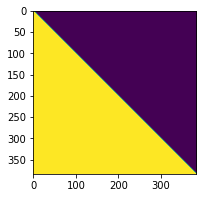

In [49]:
batch_size = 1
l_text_seq_length = 64
image_tokens_per_dim = 16
r_text_seq_length=64

att_mask = get_attention_mask(batch_size, l_text_seq_length, 
                              image_tokens_per_dim, r_text_seq_length,
                              device).detach().cpu()
print(f"Attention mask size: {att_mask.size()}")

fig, ax = plt.subplots()
ax.imshow(att_mask.squeeze())
fig.set_figwidth(3)   
fig.set_figheight(3)   
plt.show()

VQA Attention mask size: torch.Size([1, 1, 384, 384])


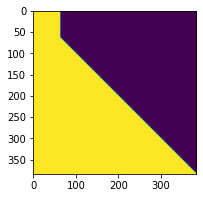

In [50]:
batch_size = 1
l_text_seq_length = 64
image_tokens_per_dim = 16
r_text_seq_length=64

att_mask = get_vqa_attention_mask(batch_size, l_text_seq_length, 
                              image_tokens_per_dim, r_text_seq_length,
                              device).detach().cpu()
print(f"VQA Attention mask size: {att_mask.size()}")

fig, ax = plt.subplots()
ax.imshow(att_mask.squeeze())
fig.set_figwidth(3)   
fig.set_figheight(3)   
plt.show()

In [51]:
def get_checkpoint(dir: str, 
                   get_last: bool = True, 
                   get_best: bool = False) -> Optional[str]:
    """
    Return naming of desirable checkpoint filename:
    - if selected `get_last` option - the very last one;
    - if selected `get_best` option - the one that showed the best performance quality;
    by default searches the last.
    """
    if not os.path.exists(dir) or not os.path.isdir(dir):
        print(f"Provided checkpoints directory do not exists: {dir}")
        return None
    if get_last:
        last_chkp = os.path.join(dir, "last.ckpt")
        if os.path.exists(last_chkp):
            return last_chkp
        else:
            print(f"Last checkpoint file by path: {last_chkp} do not exists!")
            return None
    if get_best:
        chkp_files = os.path.listdir(dir)

        best_chkp = None
        last_epoch, last_step = 0, 0
        for fn in chkp_files:
            if "last.ckpt" in fn:
                continue
            fn_epoch, fn_step = int(fn.split("_")[-2]), int(os.path.splitext(fn.split("_")[-1])[0])
            if fn_epoch > last_epoch:
                last_epoch = fn_epoch
                last_step = fn_step
                best_chkp = fn
        if best_chkp is not None:
            return best_chkp
        else:
            print(f"Best checkpoint file by path: {dir} do not exists!")
            return None

## Run fine-tuning

In [52]:
rudolph_light = RudolphLightning(vae=vae,
                                 model=model, 
                                 n_training_steps=total_training_steps,
                                 task_weights=config['trainer'].task_weights,
                                 model_params=config['model'].params,
                                 model_freeze = config['model'].freeze,
                                 scheduler_conf=config['trainer'].scheduler,
                                 bs = config['trainer'].bs)

In [54]:
%%time
try:
    trainer.fit(rudolph_light, train_dataloader, val_dataloader)

except KeyboardInterrupt:
    print(f'What for did you stopped?')  

    last_chkp_filename = get_checkpoint(config['trainer'].checkpoints.dirpath,
                                        get_last=True)

    if last_chkp_filename is not None:
        to_dir = str(MODEL_CHKP_DIR)
        print(f"Copy checkpoint: {last_chkp_filename} to folder: {to_dir}")
        shutil.copy2(last_chkp_filename, to_dir)

except Exception as err:
    print(f'Failed with {err}')
    last_chkp_filename = get_checkpoint(config['trainer'].checkpoints.dirpath,
                                    get_last=True)
    if last_chkp_filename is not None:
      to_dir = str(MODEL_CHKP_DIR)
      print(f"Copy checkpoint: {last_chkp_filename} to folder: {to_dir}")
      shutil.copy2(last_chkp_filename, to_dir)

    raise err
    
last_chkp_filename = get_checkpoint(config['trainer'].checkpoints.dirpath,
                                    get_last=True)

if last_chkp_filename is not None:
    to_dir = str(MODEL_CHKP_DIR)
    print(f"Copy checkpoint: {last_chkp_filename} to folder: {to_dir}")
    shutil.copy2(last_chkp_filename, to_dir)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type           | Params
-----------------------------------------
0 | vae   | VQGanGumbelVAE | 69.0 M
1 | model | FP16Module     | 354 M 
-----------------------------------------
423 M     Trainable params
0         Non-trainable params
423 M     Total params
1,694.571 Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=1` reached.


Copy checkpoint: /content/drive/MyDrive/DS Data&Notebooks/Ru-DOLPH/outputs/checkpoints/checkpoints_2tasks_sp_tokens_loss_rudolph-350M-v3/last.ckpt to folder: /content/drive/MyDrive/DS Data&Notebooks/Ru-DOLPH/outputs/checkpoints
CPU times: user 1h 50min 46s, sys: 8min 51s, total: 1h 59min 38s
Wall time: 2h 8min 15s


In [56]:
checkpoint_name = (MODEL_CHKP_DIR / "checkpoints_2tasks_sp_tokens_loss_rudolph-350M-v3" / "last.ckpt")
if checkpoint_name.exists():
    print(f"All OK - checkpoint exists by path:\n{checkpoint_name}")

All OK - checkpoint exists by path:
/content/drive/MyDrive/DS Data&Notebooks/Ru-DOLPH/outputs/checkpoints/checkpoints_2tasks_sp_tokens_loss_rudolph-350M-v3/last.ckpt


In [57]:
from google.colab import files

files.download(str(checkpoint_name))

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Evaluate on test set

## Infrence configuration

In [10]:
config_path = REPO_PATH / "configuration" / "multi_task_inference_cpu.yaml"

if config_path.exists():
    config = OmegaConf.load(str(config_path))
    print(OmegaConf.to_yaml(config))
else:
    print(f"No configuration file found by path:\n{config_path}")
    print(f"Check provided locations and try again.")

No configuration file found by path:
/content/ru-dolph/configuration/multi_task_inference_cpu.yaml
Check provided locations and try again.


In [21]:
# Init model's checkpoint
ckpt_folder  = MODEL_CHKP_DIR / "checkpoints_2tasks_sp_tokens_loss_rudolph-350M-v3"
# "checkpoints_2tasks_no_sp_tokens_loss_rudolph-350M-v2"
if ckpt_folder.exists():
  print(f"In checkpoints folder:")
  for fn in ckpt_folder.glob("*.ckpt"):
    print(f"\t{fn.name}")


config['model']['rudolph_weight'] = str(ckpt_folder / "last.ckpt")
config['model']['rudolph']['fp16'] = True
config['model']['rudolph']['device'] = 'cuda'

In checkpoints folder:
	last.ckpt


In [22]:
# Save
# OmegaConf.save(config=config, f=str(config_path))

## Inference Pipeline

In [23]:
import torch

from rudolph import utils
from rudalle import get_vae
from rudalle.tokenizer import get_tokenizer
from rudolph.model import (get_rudolph_model, ruDolphModel)
from rudolph.inference.embeddings import EmbeddingsGenerator

In [25]:
tokenizer = get_tokenizer()
vae = get_vae(**config['model'].vae).cuda()

# Tokenizer
print(f"Tokenizer:")
print(f"Vocab size: {tokenizer.vocab_size()}")

# VAE
print(f"VAE:")
print(f"Number of visual tokens: {vae.num_tokens}")
print(f"Number of layers: {vae.num_layers}")
print(f"Processing image size: {vae.image_size}")

tokenizer --> ready
Working with z of shape (1, 256, 32, 32) = 262144 dimensions.
vae --> ready
Tokenizer:
Vocab size: 16384
VAE:
Number of visual tokens: 8192
Number of layers: 5
Processing image size: 256


In [26]:
# Load Ru-DOLPH model
model = get_rudolph_model(**config['model'].rudolph, 
                          **config['model'].params)

# Optionally, from checkpoint
if config['model'].from_checkoint & ('rudolph_weight' in config['model']):
    filename = config['model']['rudolph_weight']
    if os.path.isfile(filename):
        print("=> loading checkpoint '{}'".format(filename))
        checkpoint = torch.load(filename, map_location=torch.device('cpu'))
        start_epoch = checkpoint['epoch']
        global_step = checkpoint['global_step']
        task_weights = checkpoint['hyper_parameters']['task_weights'] 

        if (config['model'].rudolph_weight[-3:] == 'bin'):
            model.load_state_dict(checkpoint)
        else:
            convert_checkpoint = {k[6:]: v 
                                for k, v in checkpoint['state_dict'].items() 
                                if k.startswith('model')}
            model.load_state_dict(convert_checkpoint)
        print(f"=> loaded checkpoint '{filename}' (epoch {checkpoint['epoch']})")
    else:
        print(f"=> no checkpoint found at '{filename}'")

=> loading checkpoint '/content/drive/MyDrive/DS Data&Notebooks/Ru-DOLPH/outputs/checkpoints/checkpoints_2tasks_sp_tokens_loss_rudolph-350M-v3/last.ckpt'
=> loaded checkpoint '/content/drive/MyDrive/DS Data&Notebooks/Ru-DOLPH/outputs/checkpoints/checkpoints_2tasks_sp_tokens_loss_rudolph-350M-v3/last.ckpt' (epoch 0)


In [27]:
print(config['tasks'])

predef_dataset_path = str(DATA_DIR / "test_df.csv")
test_df = pd.read_csv(predef_dataset_path, sep=';', index_col=0)
print(f"Test data: {test_df.shape}")
test_df.head()

{'vqa': True, 'captioning': True}
Test data: (21167, 6)


,task_id,left_text,image_path,right_text,stage,gt_task_id
0,unk,Посмотри на картинку и дай ответ на вопрос. Эт...,/content/drive/MyDrive/DS Data&Notebooks/Data/...,да,test,vqa
1,unk,Посмотри на картинку и дай ответ на вопрос. Чт...,/content/drive/MyDrive/DS Data&Notebooks/Data/...,лебедь,test,vqa
2,unk,Посмотри на картинку и дай ответ на вопрос. Ка...,/content/drive/MyDrive/DS Data&Notebooks/Data/...,нет,test,vqa
3,unk,Дай ответ на вопрос по картинке. Какого цвета ...,/content/drive/MyDrive/DS Data&Notebooks/Data/...,синий,test,vqa
4,unk,Посмотри на картинку и дай ответ на вопрос. Чт...,/content/drive/MyDrive/DS Data&Notebooks/Data/...,детская коляска,test,vqa


In [28]:
# Create generator
embed_generator = EmbeddingsGenerator(config_path, tokenizer=tokenizer, vae=vae, model=model)

tasks:
  vqa: true
  captioning: true
data:
  captioning:
    dataset_path: /content/drive/MyDrive/DS Data&Notebooks/Data/Image_Captioning_COCO-2014/
    train_input: /content/drive/MyDrive/DS Data&Notebooks/Data/Image_Captioning_COCO-2014/captioning.json
    train_output: /content/drive/MyDrive/DS Data&Notebooks/Data/Image_Captioning_COCO-2014/captioning_answers.json
    val_input: /content/drive/MyDrive/DS Data&Notebooks/Data/Image_Captioning_COCO-2014/captioning_val.json
    val_output: /content/drive/MyDrive/DS Data&Notebooks/Data/Image_Captioning_COCO-2014/captioning_val_answer.json
  vqa:
    dataset_path: /content/drive/MyDrive/DS Data&Notebooks/Data/VQA_VisualGenome/
    train_input: /content/drive/MyDrive/DS Data&Notebooks/Data/VQA_VisualGenome/vqa_train.json
    train_output: /content/drive/MyDrive/DS Data&Notebooks/Data/VQA_VisualGenome/vqa_train_answer.json
    val_input: /content/drive/MyDrive/DS Data&Notebooks/Data/VQA_VisualGenome/vqa_val.json
    val_output: /content/dr

In [30]:
gc.collect()
torch.cuda.empty_cache()

In [31]:
print(test_df.shape)
part_i = 0  # last for n0_sp_loss = 3
part_size = 2000

test_df_part = test_df.iloc[part_size * part_i: part_size * (part_i + 1)]
print(f"Test df part #{part_i} of size: {test_df_part.shape}")
sp_tokens_embeddings = embed_generator.generate_sp_tokens_embeddings(
    df=test_df_part
)

sp_tokens_embeddings_df = pd.DataFrame(sp_tokens_embeddings)
sp_tokens_embeddings_df['id'] = sp_tokens_embeddings_df['id'].astype('int')
sp_tokens_embeddings_df['gt_task_label'] = test_df_part['gt_task_id']
print(sp_tokens_embeddings_df.shape)

(21167, 6)
Test df part #0 of size: (2000, 6)
Loaded pre-defined dataset...
Image captioning data: (2000, 6)

Dataset size: 2000
Dataloader size: 1000 with batch size: 2


100%|██████████| 1000/1000 [10:16<00:00,  1.62it/s]

(2000, 4)


In [32]:
sp_tokens_embeddings_df.head(2)

,id,left_sp_token_embedding,right_sp_token_embedding,gt_task_label
0,0,"[14.484375, -3.8046875, -4.046875, -2.203125, ...","[38.21875, 14.84375, -0.9345703, -15.5390625, ...",vqa
1,1,"[14.515625, -3.7949219, -4.0585938, -2.1953125...","[43.1875, 18.421875, -7.2617188, -3.6230469, 2...",vqa


In [33]:
sp_tokens_embeddings_df.to_json(str(OUTPUT_DIR / "results" / f"rudolph_350M_sp_tokens_embeddings_with_sp_loss_p{part_i}_v3.json"))

(OUTPUT_DIR / "results" / f"rudolph_350M_sp_tokens_embeddings_with_sp_loss_p{part_i}_v3.json").exists()

# Visualize embeddings



## Параметры моделей и тестовых данных

### Модели:

*   **Базовая конфигурация Ru-DOLPH 350M** (без классификационного лосса)
*   **Модифицированная модель Ru-DOLPH 350M**, в которой добавлены две классификационные головы (по одной для каждого из двух токенов \<LT_spec_token> и \<RT_spec_token>), которые конфигурируются под число задач, подаваемых в модель на этапе дообучения.

Обе модели были обучены на одной эпохе для решения двух задач по генерации правого текста по левому и изображению: **Image Captioning** и **VQA**.

### Описание данных:

Для тестирования эффекта от внедрения отдельного классификационного лосса для специальных токенов \<LT_spec_token> и \<RT_spec_token> был отдельно выделен небольшой сэмпл данных из двух задач: **Image Captioning** и **VQA**.

На этапе инференса модели в качестве специальных токенов \<LT_spec_token> и \<RT_spec_token> подавались **неизвестные спец. токены: \<LT_UNK> и \<RT_UNK>** для того, что бы сравнить как модели смогут различить различные задания.

*   Файлы с формулировкой в названии "*no_sp_loss*" - были получены от базовой конфигурации Ru-DOLPH 350M. 
*   Файлы с формулировкой в названии "*with_sp_loss*" - были получены от базовой конфигурации Ru-DOLPH 350M. 

In [13]:
# Load a part of predicted embeddings
part_i = 0

if (OUTPUT_DIR / "results" / f"rudolph_350M_sp_tokens_embeddings_no_sp_loss_p{part_i}.json").exists() and \
   (OUTPUT_DIR / "results" / f"rudolph_350M_sp_tokens_embeddings_with_sp_loss_p{part_i}_v3.json").exists():
   print(f"Both embeddings for test data part #{part_i} exists. Loading...")
   no_sp_loss_embeddings_df = pd.read_json(str(OUTPUT_DIR / "results" / f"rudolph_350M_sp_tokens_embeddings_no_sp_loss_p{part_i}.json"))
   with_sp_loss_embeddings_df = pd.read_json(str(OUTPUT_DIR / "results" / f"rudolph_350M_sp_tokens_embeddings_with_sp_loss_p{part_i}_v3.json"))
   print(f"No special tokens loss df size: {no_sp_loss_embeddings_df.shape}")
   print(f"With special tokens loss df size: {with_sp_loss_embeddings_df.shape}")

else:
  print(f"One (or both) embeddings for test data part #{part_i} do/does not exist!")

Both embeddings for test data part #0 exists. Loading...
No special tokens loss df size: (2000, 4)
With special tokens loss df size: (2000, 4)


In [14]:
no_sp_loss_embeddings_df.head(2)

,id,left_sp_token_embedding,right_sp_token_embedding,gt_task_label
0,0,"[-2.55078125, -11.2265625, 7.85546875, 16.625,...","[-6.765625, -12.3359375, -15.75, -11.3125, -5....",vqa
1,1,"[-2.546875, -11.234375, 7.875, 16.625, 11.8593...","[-15.578125, -18.203125, -37.59375, -12.882812...",vqa


In [15]:
ns_gt_task_label = no_sp_loss_embeddings_df['gt_task_label']
ns_left_sp_token_embedding = np.vstack(no_sp_loss_embeddings_df['left_sp_token_embedding'].values)
ns_right_sp_token_embedding = np.vstack(no_sp_loss_embeddings_df['right_sp_token_embedding'].values)
print(f"No special tokens loss data:")
print(f"Special tokens embeddings size, left: {ns_left_sp_token_embedding.shape}"
  f" and right {ns_right_sp_token_embedding.shape}")
print("Task labels distribution:")
print(collections.Counter(ns_gt_task_label))

ws_gt_task_label = with_sp_loss_embeddings_df['gt_task_label']
ws_left_sp_token_embedding = np.vstack(with_sp_loss_embeddings_df['left_sp_token_embedding'].values)
ws_right_sp_token_embedding = np.vstack(with_sp_loss_embeddings_df['right_sp_token_embedding'].values)
print(f"\nWith special tokens loss data:")
print(f"Special tokens embeddings size, left: {ws_left_sp_token_embedding.shape}"
  f" and right {ws_right_sp_token_embedding.shape}")
print("Task labels distribution:")
print(collections.Counter(ws_gt_task_label))

No special tokens loss data:
Special tokens embeddings size, left: (2000, 1024) and right (2000, 1024)
Task labels distribution:
Counter({'vqa': 1609, 'captioning': 391})

With special tokens loss data:
Special tokens embeddings size, left: (2000, 1024) and right (2000, 1024)
Task labels distribution:
Counter({'vqa': 1609, 'captioning': 391})


## PCA

In [12]:
from sklearn.decomposition import PCA

### Left token

In [16]:
%%time
ns_pca_left = PCA(n_components=2)
ns_left_sp_token_embedding_2d = ns_pca_left.fit(ns_left_sp_token_embedding).transform(ns_left_sp_token_embedding)
# Percentage of variance explained for each components
print("No special tokens loss data explained variance ratio: %s"
    % str(ns_pca_left.explained_variance_ratio_)
)

ws_pca_left = PCA(n_components=2)
ws_left_sp_token_embedding_2d = ws_pca_left.fit(ws_left_sp_token_embedding).transform(ws_left_sp_token_embedding)
# Percentage of variance explained for each components
print("With special tokens loss data explained variance ratio: %s"
    % str(ws_pca_left.explained_variance_ratio_)
)

No special tokens loss data explained variance ratio: [0.01943112 0.01680886]
With special tokens loss data explained variance ratio: [0.02780971 0.02455541]
CPU times: user 662 ms, sys: 248 ms, total: 910 ms
Wall time: 1.27 s


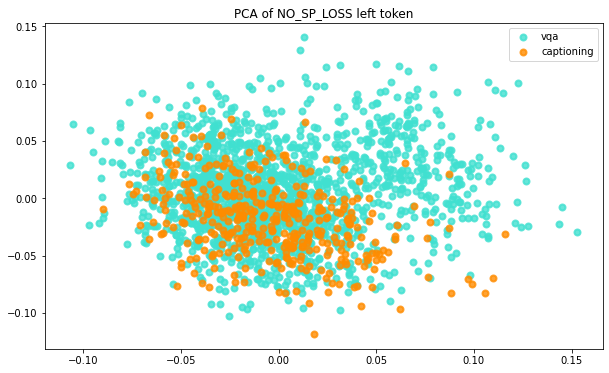

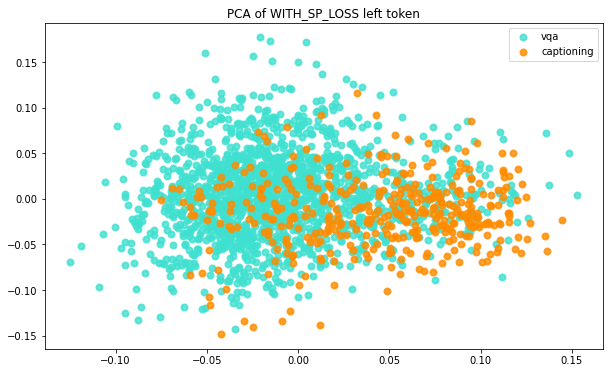

In [17]:
plt.figure(figsize=(10, 6))
colors = ["turquoise", "darkorange"]
task_names = ['vqa', 'captioning']
lw = 2

for color, i, task_name in zip(colors, [0, 1], task_names):
    plt.scatter(
        ns_left_sp_token_embedding_2d[ns_gt_task_label == task_name, 0], 
        ns_left_sp_token_embedding_2d[ns_gt_task_label == task_name, 1], 
        color=color, alpha=0.8, lw=lw, label=task_name
    )
plt.legend(loc="best", shadow=False, scatterpoints=1)
plt.title("PCA of NO_SP_LOSS left token")

plt.figure(figsize=(10, 6))
for color, i, task_name in zip(colors, [0, 1], task_names):
    plt.scatter(
        ws_left_sp_token_embedding_2d[ws_gt_task_label == task_name, 0], 
        ws_left_sp_token_embedding_2d[ws_gt_task_label == task_name, 1], 
        color=color, alpha=0.8, lw=lw, label=task_name
    )
plt.legend(loc="best", shadow=False, scatterpoints=1)
plt.title("PCA of WITH_SP_LOSS left token")

plt.show()

### Right token

In [18]:
%%time
ns_pca_right = PCA(n_components=2)
ns_right_sp_token_embedding_2d = ns_pca_right.fit(ns_right_sp_token_embedding).transform(ns_right_sp_token_embedding)
# Percentage of variance explained for each components
print("No special tokens loss data explained variance ratio: %s"
    % str(ns_pca_right.explained_variance_ratio_)
)

ws_pca_right = PCA(n_components=2)
ws_right_sp_token_embedding_2d = ws_pca_right.fit(ws_right_sp_token_embedding).transform(ws_right_sp_token_embedding)
# Percentage of variance explained for each components
print("With special tokens loss data explained variance ratio: %s"
    % str(ws_pca_right.explained_variance_ratio_)
)

No special tokens loss data explained variance ratio: [0.43520307 0.23960865]
With special tokens loss data explained variance ratio: [0.44223001 0.18433475]
CPU times: user 550 ms, sys: 74.2 ms, total: 624 ms
Wall time: 330 ms


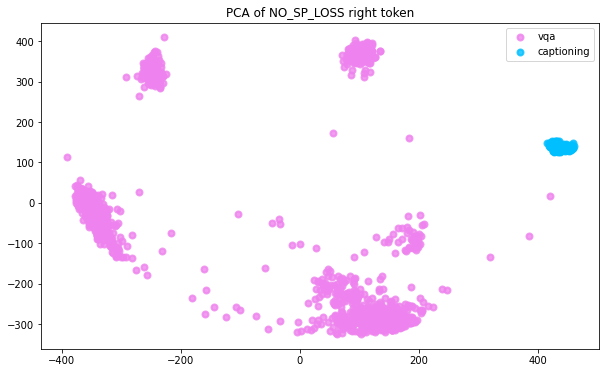

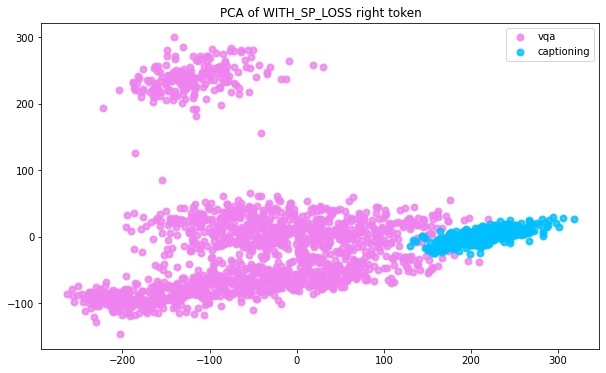

In [19]:
plt.figure(figsize=(10, 6))
colors = ["violet", "deepskyblue"]
task_names = ['vqa', 'captioning']
lw = 2

for color, i, task_name in zip(colors, [0, 1], task_names):
    plt.scatter(
        ns_right_sp_token_embedding_2d[ns_gt_task_label == task_name, 0], 
        ns_right_sp_token_embedding_2d[ns_gt_task_label == task_name, 1], 
        color=color, alpha=0.8, lw=lw, label=task_name
    )
plt.legend(loc="best", shadow=False, scatterpoints=1)
plt.title("PCA of NO_SP_LOSS right token")

plt.figure(figsize=(10, 6))
for color, i, task_name in zip(colors, [0, 1], task_names):
    plt.scatter(
        ws_right_sp_token_embedding_2d[ws_gt_task_label == task_name, 0], 
        ws_right_sp_token_embedding_2d[ws_gt_task_label == task_name, 1], 
        color=color, alpha=0.8, lw=lw, label=task_name
    )
plt.legend(loc="best", shadow=False, scatterpoints=1)
plt.title("PCA of WITH_SP_LOSS right token")

plt.show()

## UMAP

In [20]:
# !pip install umap-learn

import umap

### Left token

In [21]:
%%time
ns_umap_left = umap.UMAP()
ns_left_sp_token_embedding_2d = ns_umap_left.fit_transform(ns_left_sp_token_embedding)

ws_umap_left = umap.UMAP()
ws_left_sp_token_embedding_2d = ws_umap_left.fit_transform(ws_left_sp_token_embedding)

CPU times: user 34.8 s, sys: 387 ms, total: 35.2 s
Wall time: 27.6 s


In [22]:
%%time
umap_left = umap.UMAP()
umap_left.fit(np.vstack([ns_left_sp_token_embedding, ws_left_sp_token_embedding]))

ns_left_sp_token_embedding_2d = umap_left.transform(ns_left_sp_token_embedding)
ws_left_sp_token_embedding_2d = umap_left.transform(ws_left_sp_token_embedding)

CPU times: user 1min 16s, sys: 813 ms, total: 1min 17s
Wall time: 1min 7s


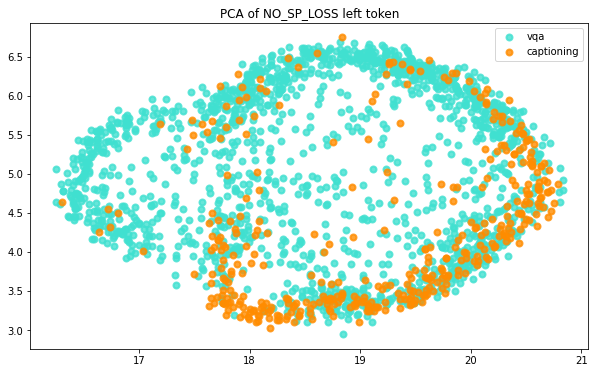

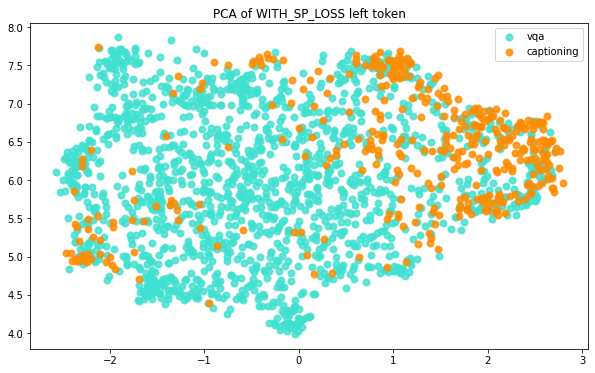

In [23]:
plt.figure(figsize=(10, 6))
colors = ["turquoise", "darkorange"]
task_names = ['vqa', 'captioning']
lw = 2

for color, i, task_name in zip(colors, [0, 1], task_names):
    plt.scatter(
        ns_left_sp_token_embedding_2d[ns_gt_task_label == task_name, 0], 
        ns_left_sp_token_embedding_2d[ns_gt_task_label == task_name, 1], 
        color=color, alpha=0.8, lw=lw, label=task_name
    )
plt.legend(loc="best", shadow=False, scatterpoints=1)
plt.title("UMAP of NO_SP_LOSS left token")

plt.figure(figsize=(10, 6))
for color, i, task_name in zip(colors, [0, 1], task_names):
    plt.scatter(
        ws_left_sp_token_embedding_2d[ws_gt_task_label == task_name, 0], 
        ws_left_sp_token_embedding_2d[ws_gt_task_label == task_name, 1], 
        color=color, alpha=0.8, lw=lw, label=task_name
    )
plt.legend(loc="best", shadow=False, scatterpoints=1)
plt.title("UMAP of WITH_SP_LOSS left token")

plt.show()

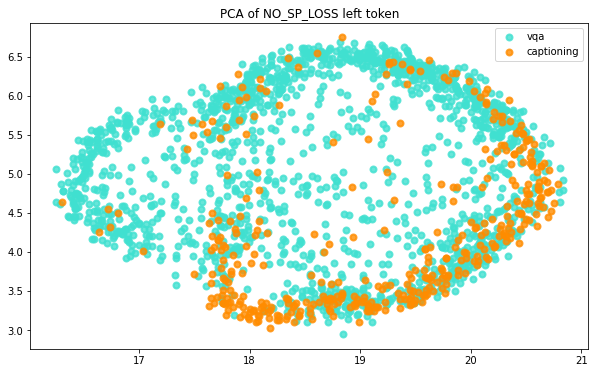

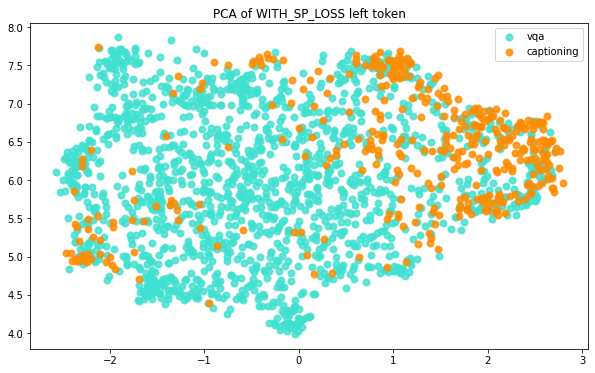

In [24]:
plt.figure(figsize=(10, 6))
colors = ["turquoise", "darkorange"]
task_names = ['vqa', 'captioning']
lw = 2

for color, i, task_name in zip(colors, [0, 1], task_names):
    plt.scatter(
        ns_left_sp_token_embedding_2d[ns_gt_task_label == task_name, 0], 
        ns_left_sp_token_embedding_2d[ns_gt_task_label == task_name, 1], 
        color=color, alpha=0.8, lw=lw, label=task_name
    )
plt.legend(loc="best", shadow=False, scatterpoints=1)
plt.title("UMAP of NO_SP_LOSS left token")

plt.figure(figsize=(10, 6))
for color, i, task_name in zip(colors, [0, 1], task_names):
    plt.scatter(
        ws_left_sp_token_embedding_2d[ws_gt_task_label == task_name, 0], 
        ws_left_sp_token_embedding_2d[ws_gt_task_label == task_name, 1], 
        color=color, alpha=0.8, lw=lw, label=task_name
    )
plt.legend(loc="best", shadow=False, scatterpoints=1)
plt.title("UMAP of WITH_SP_LOSS left token")

plt.show()

### Right token

In [25]:
%%time
ns_umap_right = umap.UMAP()
ns_right_sp_token_embedding_2d = ns_umap_right.fit_transform(ns_right_sp_token_embedding)

ws_umap_right = umap.UMAP()
ws_right_sp_token_embedding_2d = ws_umap_right.fit_transform(ws_right_sp_token_embedding)

CPU times: user 33.6 s, sys: 387 ms, total: 34 s
Wall time: 33.7 s


In [26]:
%%time
umap_right = umap.UMAP()
umap_right.fit(np.vstack([ns_right_sp_token_embedding, ws_right_sp_token_embedding]))

jns_right_sp_token_embedding_2d = umap_right.transform(ns_right_sp_token_embedding)
jws_right_sp_token_embedding_2d = umap_right.transform(ws_right_sp_token_embedding)

CPU times: user 1min 10s, sys: 646 ms, total: 1min 11s
Wall time: 1min 3s


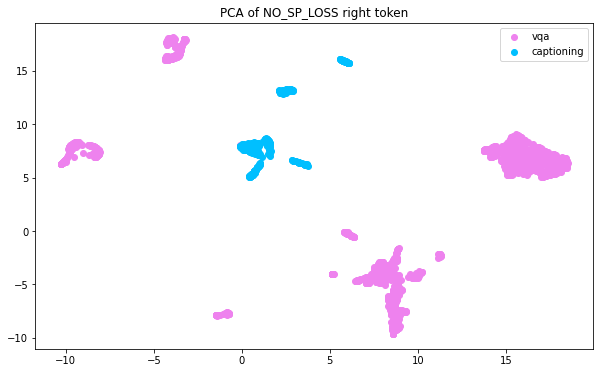

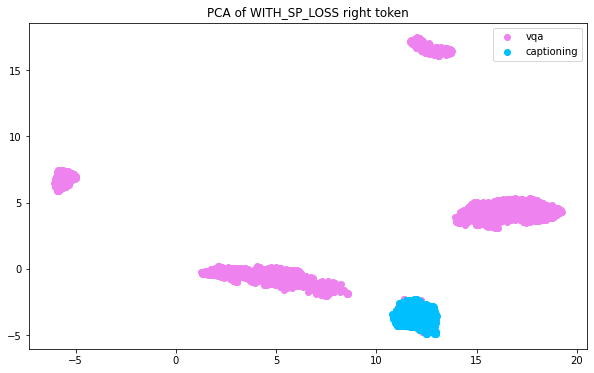

In [34]:
plt.figure(figsize=(10, 6))
colors = ["violet", "deepskyblue"]
task_names = ['vqa', 'captioning']
lw = 1

for color, i, task_name in zip(colors, [0, 1], task_names):
    plt.scatter(
        ns_right_sp_token_embedding_2d[ns_gt_task_label == task_name, 0], 
        ns_right_sp_token_embedding_2d[ns_gt_task_label == task_name, 1], 
        color=color, alpha=1.0, lw=lw, label=task_name
    )
plt.legend(loc="best", shadow=False, scatterpoints=1)
plt.title("UMAP of NO_SP_LOSS right token")

plt.figure(figsize=(10, 6))
for color, i, task_name in zip(colors, [0, 1], task_names):
    plt.scatter(
        ws_right_sp_token_embedding_2d[ws_gt_task_label == task_name, 0], 
        ws_right_sp_token_embedding_2d[ws_gt_task_label == task_name, 1], 
        color=color, alpha=1.0, lw=lw, label=task_name
    )
plt.legend(loc="best", shadow=False, scatterpoints=1)
plt.title("UMAP of WITH_SP_LOSS right token")

plt.show()

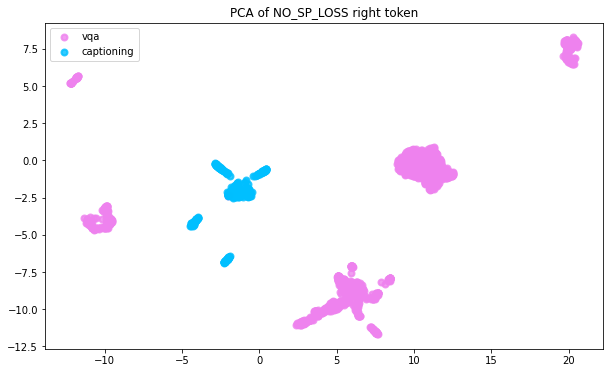

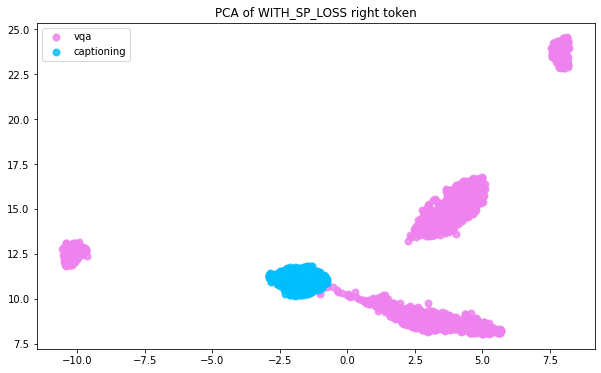

In [30]:
plt.figure(figsize=(10, 6))
colors = ["violet", "deepskyblue"]
task_names = ['vqa', 'captioning']
lw = 2

for color, i, task_name in zip(colors, [0, 1], task_names):
    plt.scatter(
        jns_right_sp_token_embedding_2d[ns_gt_task_label == task_name, 0], 
        jns_right_sp_token_embedding_2d[ns_gt_task_label == task_name, 1], 
        color=color, alpha=0.8, lw=lw, label=task_name
    )
plt.legend(loc="best", shadow=False, scatterpoints=1)
plt.title("UMAP of NO_SP_LOSS right token")

plt.figure(figsize=(10, 6))
for color, i, task_name in zip(colors, [0, 1], task_names):
    plt.scatter(
        jws_right_sp_token_embedding_2d[ws_gt_task_label == task_name, 0], 
        jws_right_sp_token_embedding_2d[ws_gt_task_label == task_name, 1], 
        color=color, alpha=0.8, lw=lw, label=task_name
    )
plt.legend(loc="best", shadow=False, scatterpoints=1)
plt.title("UMAP of WITH_SP_LOSS right token")

plt.show()

## T-SNE

In [39]:
from sklearn.manifold import TSNE

### Left token

In [44]:
%%time
tsne_left = TSNE(n_components=2, learning_rate='auto',
                  init='pca', perplexity=30)

ns_left_sp_token_embedding_2d = tsne_left.fit_transform(ns_left_sp_token_embedding)
ws_left_sp_token_embedding_2d = tsne_left.fit_transform(ws_left_sp_token_embedding)

CPU times: user 1min 13s, sys: 1.56 s, total: 1min 15s
Wall time: 41.6 s


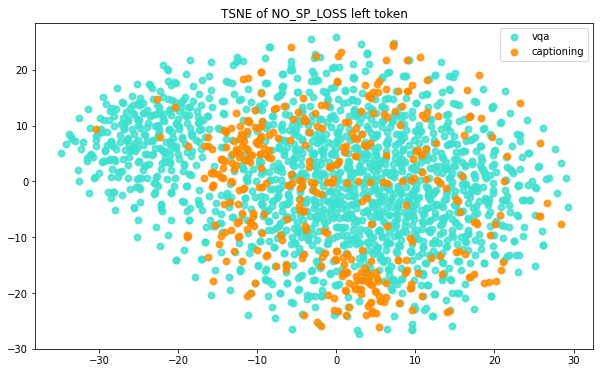

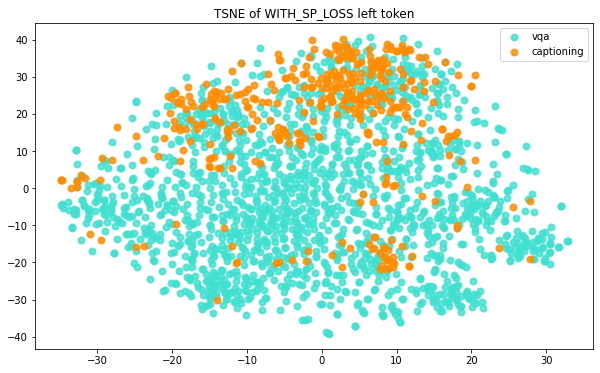

In [45]:
plt.figure(figsize=(10, 6))
colors = ["turquoise", "darkorange"]
task_names = ['vqa', 'captioning']
lw = 2

for color, i, task_name in zip(colors, [0, 1], task_names):
    plt.scatter(
        ns_left_sp_token_embedding_2d[ns_gt_task_label == task_name, 0], 
        ns_left_sp_token_embedding_2d[ns_gt_task_label == task_name, 1], 
        color=color, alpha=0.8, lw=lw, label=task_name
    )
plt.legend(loc="best", shadow=False, scatterpoints=1)
plt.title("TSNE of NO_SP_LOSS left token")

plt.figure(figsize=(10, 6))
for color, i, task_name in zip(colors, [0, 1], task_names):
    plt.scatter(
        ws_left_sp_token_embedding_2d[ws_gt_task_label == task_name, 0], 
        ws_left_sp_token_embedding_2d[ws_gt_task_label == task_name, 1], 
        color=color, alpha=0.8, lw=lw, label=task_name
    )
plt.legend(loc="best", shadow=False, scatterpoints=1)
plt.title("TSNE of WITH_SP_LOSS left token")

plt.show()

### Right token

In [50]:
%%time
tsne_right = TSNE(n_components=2, learning_rate='auto',
                  init='random', perplexity=3)

ns_right_sp_token_embedding_2d = tsne_right.fit_transform(ns_right_sp_token_embedding)
ws_right_sp_token_embedding_2d = tsne_right.fit_transform(ws_right_sp_token_embedding)

CPU times: user 43.7 s, sys: 389 ms, total: 44 s
Wall time: 26.2 s


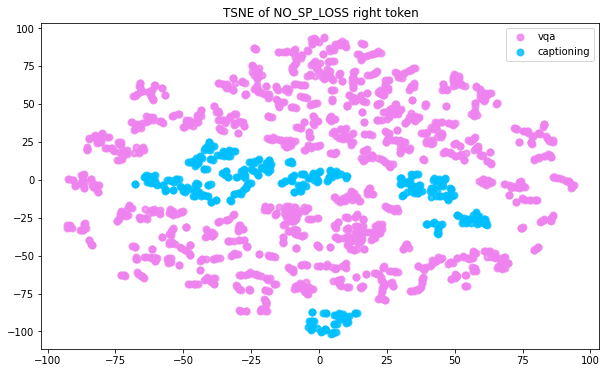

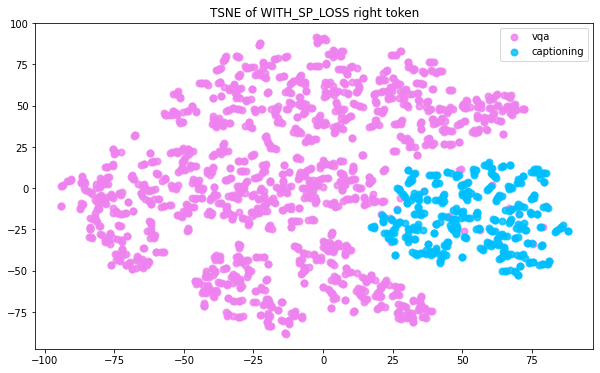

In [51]:
plt.figure(figsize=(10, 6))
colors = ["violet", "deepskyblue"]
task_names = ['vqa', 'captioning']
lw = 2

for color, i, task_name in zip(colors, [0, 1], task_names):
    plt.scatter(
        ns_right_sp_token_embedding_2d[ns_gt_task_label == task_name, 0], 
        ns_right_sp_token_embedding_2d[ns_gt_task_label == task_name, 1], 
        color=color, alpha=0.8, lw=lw, label=task_name
    )
plt.legend(loc="best", shadow=False, scatterpoints=1)
plt.title("TSNE of NO_SP_LOSS right token")

plt.figure(figsize=(10, 6))
for color, i, task_name in zip(colors, [0, 1], task_names):
    plt.scatter(
        ws_right_sp_token_embedding_2d[ws_gt_task_label == task_name, 0], 
        ws_right_sp_token_embedding_2d[ws_gt_task_label == task_name, 1], 
        color=color, alpha=0.8, lw=lw, label=task_name
    )
plt.legend(loc="best", shadow=False, scatterpoints=1)
plt.title("TSNE of WITH_SP_LOSS right token")

plt.show()

In [56]:
%%time
tsne_right = TSNE(n_components=2, learning_rate='auto',
                  init='random', perplexity=3, metric='cosine')

ns_right_sp_token_embedding_2d_pca = tsne_right.fit_transform(ns_right_sp_token_embedding)
ws_right_sp_token_embedding_2d_pca = tsne_right.fit_transform(ws_right_sp_token_embedding)

CPU times: user 41.6 s, sys: 909 ms, total: 42.5 s
Wall time: 23.4 s


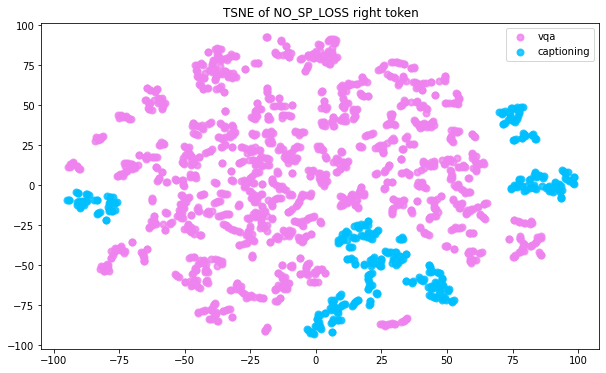

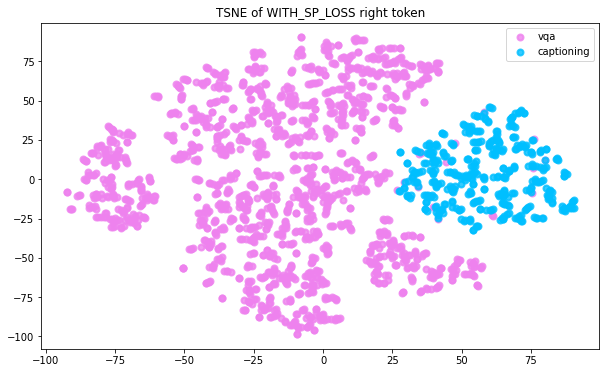

In [57]:
plt.figure(figsize=(10, 6))
colors = ["violet", "deepskyblue"]
task_names = ['vqa', 'captioning']
lw = 2

for color, i, task_name in zip(colors, [0, 1], task_names):
    plt.scatter(
        ns_right_sp_token_embedding_2d_pca[ns_gt_task_label == task_name, 0], 
        ns_right_sp_token_embedding_2d_pca[ns_gt_task_label == task_name, 1], 
        color=color, alpha=0.8, lw=lw, label=task_name
    )
plt.legend(loc="best", shadow=False, scatterpoints=1)
plt.title("TSNE of NO_SP_LOSS right token")

plt.figure(figsize=(10, 6))
for color, i, task_name in zip(colors, [0, 1], task_names):
    plt.scatter(
        ws_right_sp_token_embedding_2d_pca[ws_gt_task_label == task_name, 0], 
        ws_right_sp_token_embedding_2d_pca[ws_gt_task_label == task_name, 1], 
        color=color, alpha=0.8, lw=lw, label=task_name
    )
plt.legend(loc="best", shadow=False, scatterpoints=1)
plt.title("TSNE of WITH_SP_LOSS right token")

plt.show()

# Результаты

По внешнему виду двухмерных распределений векторных представлений специальных токенов на тестовом наборе данных, заметно:


1.   Для **левого специального токена** разница между пониманием типа решаемой задачи моделями не велика - группы векторов примерно однаково распределены для обеих
2.   Однако, для **правого специального токена** уже можно отметить, что кластеры его векторов группируются более плотно по задачам для модифицированной модели, чем для эмбеддингов, полученных на инференсе от базовой конфигурации Ru-DOLPH-a (уже после первой эпохи дообучения)

Таким образом, есть возможность обучить модель самостоятельно определять тип задачи, которую ее просят решить путем регулировки:

*   Весов классификационного лосса
*   Дообучением на 1+ эпохах
*   Разделением весов классификационного лосса для разных токенов - то есть придать правому спец. токену больший вес, чем левому - что в преспективе, может дать куда лучшие примеры сгенерированного текста. 



